In [3]:
# display, transform, read, split ...
import numpy as np
import os
import matplotlib.pyplot as plt
import splitfolders

# tensorflow
import tensorflow.keras as keras
import tensorflow as tf

# image processing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [4]:

# Add normalization to the ImageDataGenerator for train, test, and validation
# Add more data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

# define classes name
class_names = ['ECG Images of Myocardial Infarction Patients','ECG Images of Patient that have abnormal heartbeat','ECG Images of Patient that have History of MI','Normal Person ECG Images']

In [3]:
splitfolders.ratio("./data", output="./data-split", seed=1337, ratio=(0.7, 0.2, 0.1), group_prefix=None, move=False)


In [5]:
# training data
train_generator = train_datagen.flow_from_directory( 
    directory="./data-split/train", 
    classes = class_names,
    target_size=(224, 224),  
    batch_size=32, 
    class_mode="categorical", 
    
)


Found 648 images belonging to 4 classes.


In [6]:
# test data
test_generator = test_datagen.flow_from_directory( 
    directory="./data-split/test", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="categorical", 

)

Found 97 images belonging to 4 classes.


In [8]:
# validation data
valid_generator = val_datagen.flow_from_directory( 
    directory="./data-split/val/", 
    classes = class_names,
    target_size=(224, 224), 
    batch_size=32, 
    class_mode="categorical",
     
)

Found 183 images belonging to 4 classes.


In [9]:
# ResNet50 model
resnet_50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in resnet_50.layers:
    layer.trainable = False

In [10]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

x = resnet_50.output
x = layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = layers.Dense(4, activation='softmax')(x)
model = Model(inputs=resnet_50.input, outputs=predictions)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def trainModel(model, epochs, optimizer):
    batch_size = 32
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
    
    return model.fit(train_generator,
                     validation_data=valid_generator,
                     epochs=epochs,
                     batch_size=batch_size,
                     callbacks=[early_stopping, reduce_lr])

In [12]:
# launch the training
model_history = trainModel(model = model, epochs = 50, optimizer = "Adam")

Epoch 1/50


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:124: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.4449 - loss: 1.4023 - val_accuracy: 0.4426 - val_loss: 1.3564 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.7911 - loss: 0.5865 - val_accuracy: 0.5847 - val_loss: 1.0344 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8347 - loss: 0.4371 - val_accuracy: 0.6230 - val_loss: 0.9684 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.8704 - loss: 0.3307 - val_accuracy: 0.6393 - val_loss: 0.9055 - learning_rate: 0.0010
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9114 - loss: 0.2530 - val_accuracy: 0.5683 - val_loss: 0.9011 - learning_rate: 0.0010
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.9261 - loss: 0.2527 - val_accuracy: 0.6995 - val_loss: 0.8128 - learning_rate: 0.0010
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.9326 - loss: 0.2452 - val_accuracy: 0.7049 - va

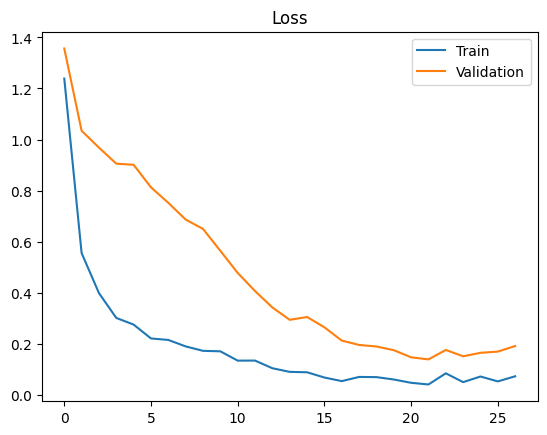

In [13]:
loss_train_curve = model_history.history["loss"]
loss_val_curve = model_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

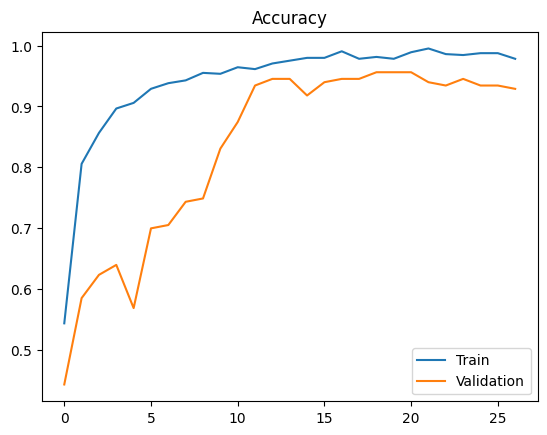

In [14]:
acc_train_curve = model_history.history["accuracy"]
acc_val_curve = model_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print("The best accuracy is: ", test_acc*100)
print("The test loss is: ", test_loss)


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9533 - loss: 0.2009
The best accuracy is:  94.84536051750183
The test loss is:  0.24559739232063293


In [22]:
# Load the image for test
img_path = './data-split/test/Normal Person ECG Images/Normal(9).jpg' 
img = image.load_img(img_path, target_size=(224, 224))

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class
predicted_class_index = np.argmax(predictions[0])
predicted_class = class_names[predicted_class_index]

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted class: Normal Person ECG Images


In [ ]:
img = tf.keras.preprocessing.image.load_img('./dataset/ECG Images of Patient that have abnormal heart beats/Normal (2).jpg', target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.array([img_array]) 
img

In [17]:
model.save('ECG-train.h5');

In [18]:
model.save('ECG-train.keras');